In [1]:
import pandas as pd
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(
    "train.csv",
    names=(
        ["velocity", "steering_angle", "next_wp_angle", "next_wp_dist"] +
        [f"wheel_on_track_{i}" for i in ("front_r", "front_l", "rear_r", "rear_l")] +
        [f"sensor_readings_{i}" for i in range(13)] + 
        ["target_steer", "target_throttle"]
    )
)
display(data)

,velocity,steering_angle,next_wp_angle,next_wp_dist,wheel_on_track_front_r,wheel_on_track_front_l,wheel_on_track_rear_r,wheel_on_track_rear_l,sensor_readings_0,sensor_readings_1,...,sensor_readings_5,sensor_readings_6,sensor_readings_7,sensor_readings_8,sensor_readings_9,sensor_readings_10,sensor_readings_11,sensor_readings_12,target_steer,target_throttle
0,0.000000,0.000000,-0.000000,75.000000,1.0,1.0,1.0,1.0,19.248714,22.413555,...,142.71890,118.638245,93.82548,56.399870,36.999990,27.670198,22.413551,19.248713,0.0,1.0
1,0.828015,0.000000,-0.000000,74.986220,1.0,1.0,1.0,1.0,19.248713,22.413555,...,142.70247,118.624480,93.81613,56.399876,36.999992,27.670198,22.413550,19.248710,0.0,1.0
2,1.948009,0.000000,-0.000000,74.942200,1.0,1.0,1.0,1.0,19.248713,22.413555,...,142.64992,118.580444,93.78629,56.399870,36.999990,27.670198,22.413551,19.248710,0.0,1.0
3,2.667005,0.000000,-0.000000,74.903140,1.0,1.0,1.0,1.0,19.248713,22.413555,...,142.60329,118.541380,93.75979,56.399880,36.999990,27.670198,22.413551,19.248710,0.0,1.0
4,3.329196,0.000000,-0.000000,74.857925,1.0,1.0,1.0,1.0,19.248713,22.413555,...,142.54935,118.496170,93.72911,56.399876,36.999990,27.670198,22.413550,19.248710,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22434,111.864430,-0.000550,-0.014029,79.602110,1.0,1.0,1.0,1.0,10.752769,13.432245,...,205.00000,205.000000,205.00000,60.066605,44.006474,35.287205,30.107172,26.968327,0.0,1.0
22435,112.142600,-0.000457,-0.014303,77.714990,1.0,1.0,1.0,1.0,11.032754,13.759393,...,205.00000,205.000000,205.00000,59.576992,43.636185,34.981594,29.840424,26.724796,0.0,1.0
22436,112.396935,-0.000382,-0.014587,75.873480,1.0,1.0,1.0,1.0,11.306391,14.079337,...,205.00000,205.000000,205.00000,59.097805,43.273735,34.682728,29.579573,26.487055,0.0,1.0
22437,112.660560,-0.000319,-0.014911,74.003940,1.0,1.0,1.0,1.0,11.583961,14.404110,...,205.00000,205.000000,205.00000,58.609833,42.905266,34.379086,29.314636,26.245350,0.0,1.0


In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True, clip=False)
scaler.fit(data)

,feature_range,"(-1, ...)"
,copy,True
,clip,False


In [4]:
scaler.data_min_, scaler.data_max_, scaler.data_range_, scaler.feature_range

(array([ 0.0000000e+00, -5.2359880e-01, -3.0456755e+00,  1.6266878e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         6.6974787e-03,  6.7289400e-03,  2.9691972e-03,  4.1475534e-02,
         3.6709644e-02,  5.7889264e-02,  4.3229107e-02,  5.0457990e-03,
         5.3765584e-04,  2.3197293e-02,  1.5419563e-02,  1.9077759e-03,
         5.1509717e-04, -1.0000000e+00, -1.0000000e+00]),
 array([157.69334  ,   0.5235988,   2.6147368, 252.00623  ,   1.       ,
          1.       ,   1.       ,   1.       , 205.       , 205.       ,
        205.       , 205.       , 205.       , 205.       , 205.       ,
        205.       , 205.       , 205.       , 205.       , 205.       ,
        205.       ,   1.       ,   1.       ]),
 array([157.69334   ,   1.0471976 ,   5.6604123 , 250.3795422 ,
          1.        ,   1.        ,   1.        ,   1.        ,
        204.99330252, 204.99327106, 204.9970308 , 204.95852447,
        204.96329036, 204.94211074, 204.95677089,

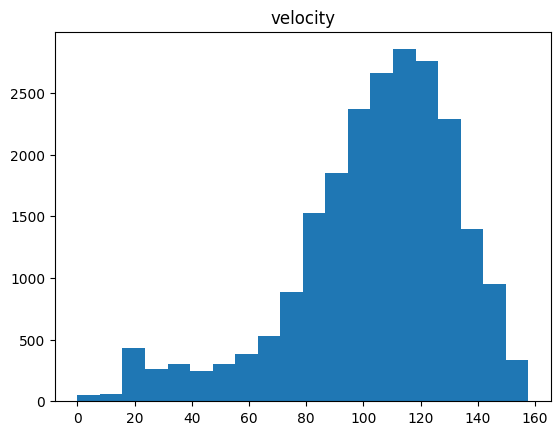

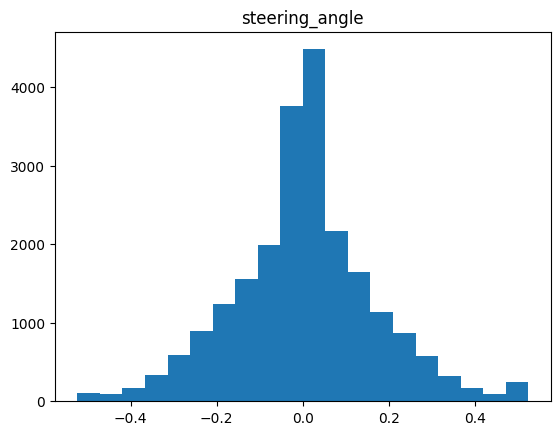

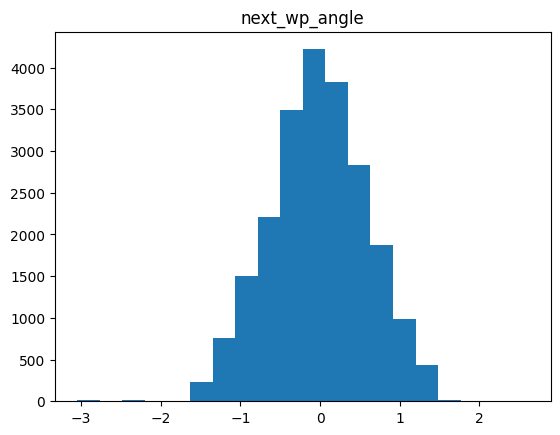

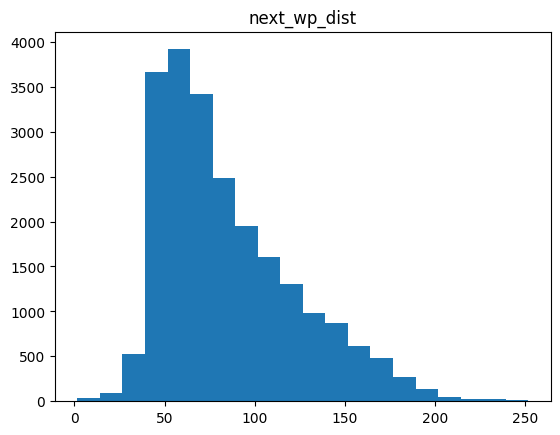

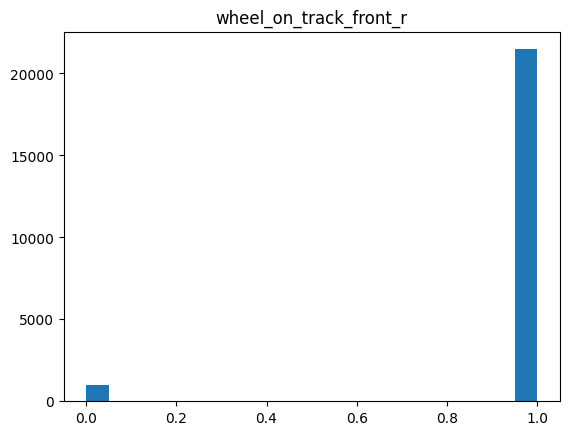

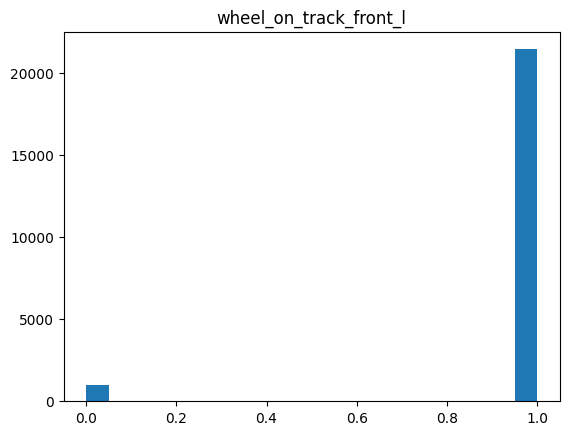

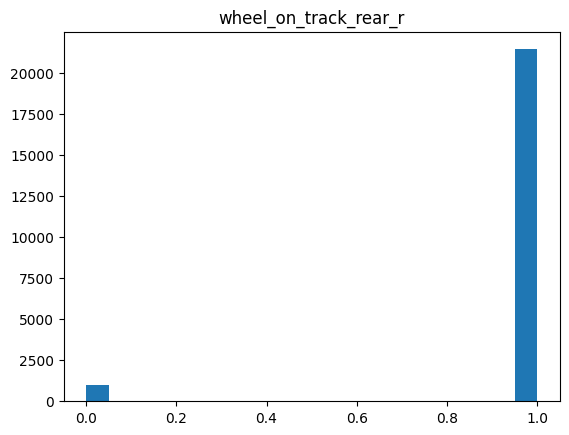

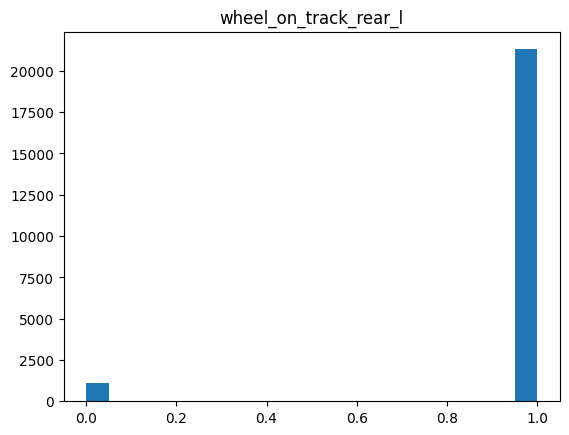

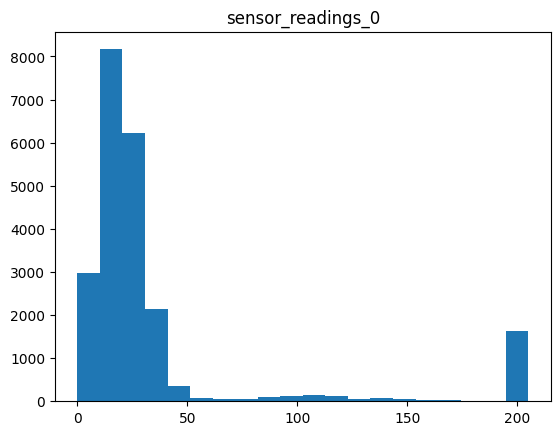

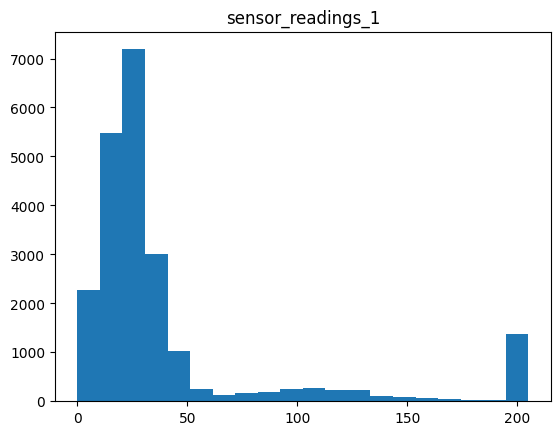

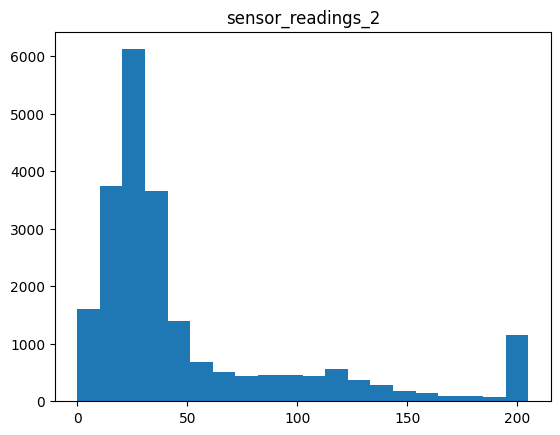

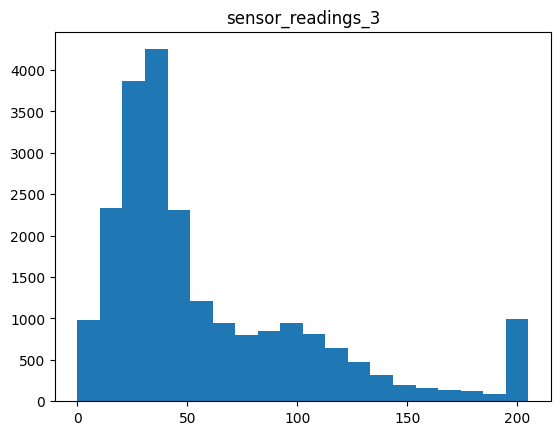

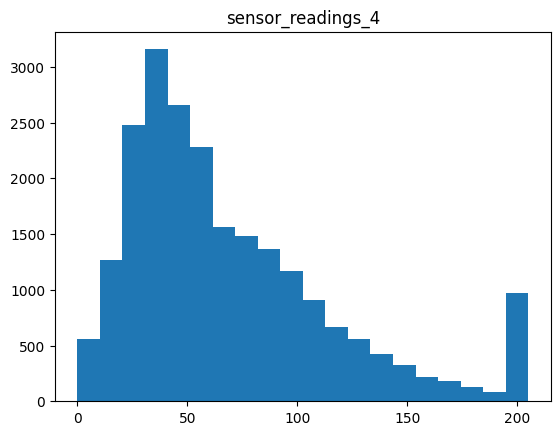

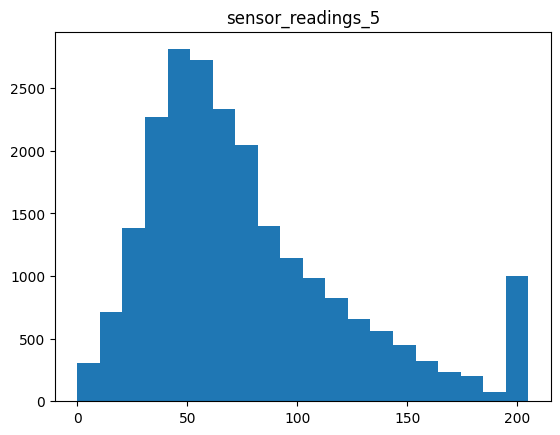

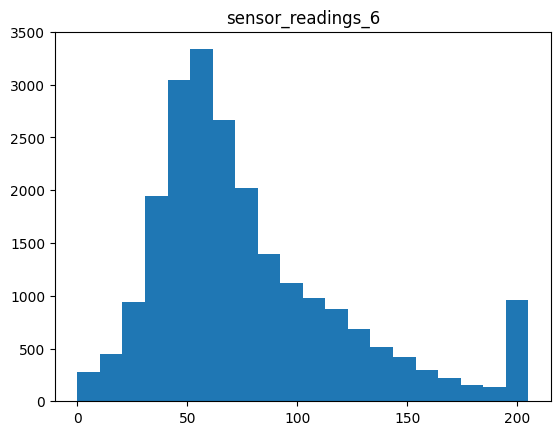

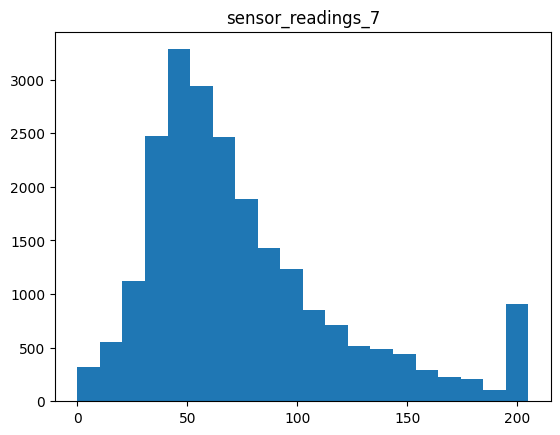

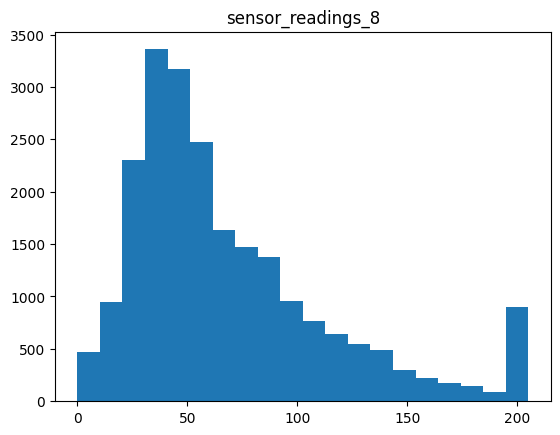

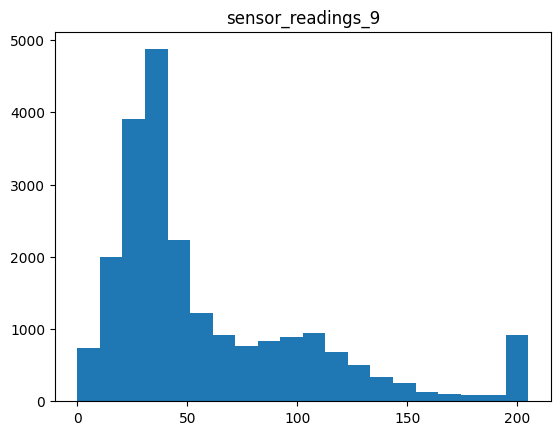

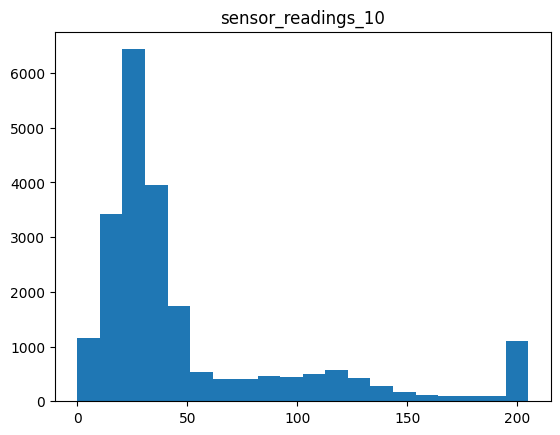

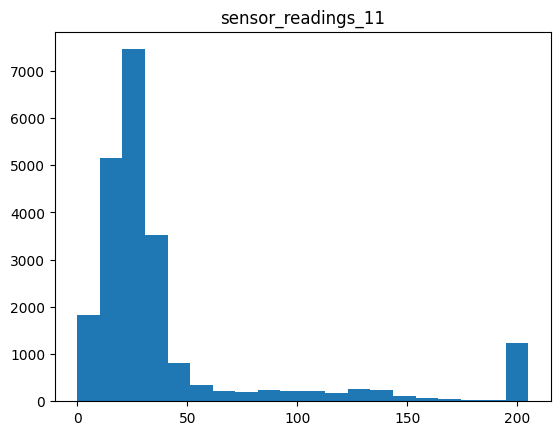

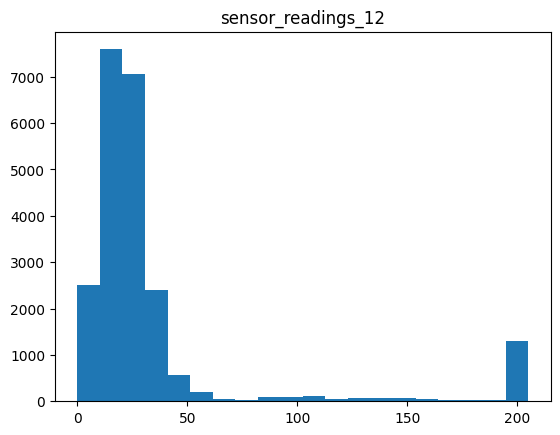

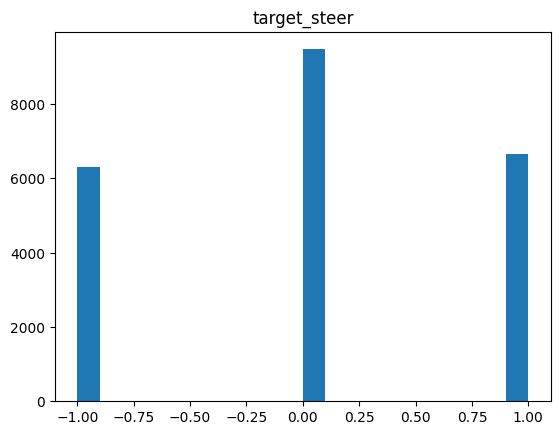

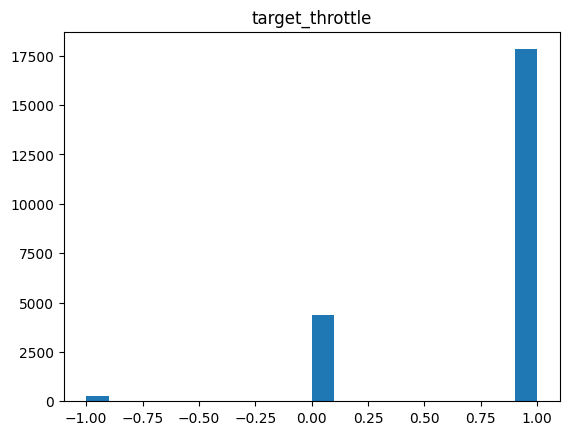

In [5]:
for column in data.columns:
    plt.figure()
    plt.title(column)
    plt.hist(data[column], bins=20)
    plt.show()

In [6]:
x = data[data.columns[:-2]].to_numpy()
x.shape

(22439, 21)

In [7]:
y = data[data.columns[-2:]].to_numpy()
y.shape

(22439, 2)

In [8]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.1, random_state=0)

In [9]:
class RacerDataset(Dataset):
    def __init__(self, x, y):
        self.x = t.tensor(x, dtype=t.float32)
        self.y = t.tensor(y, dtype=t.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = RacerDataset(x_train, y_train)
validation_dataset = RacerDataset(x_validation, y_validation)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [10]:
class Model(nn.Module):
    def __init__(self, input_dim, scaler):
        super().__init__()

        min_, max_ = scaler.feature_range
        scale = (max_ - min_) / (scaler.data_max_ - scaler.data_min_)
        bias = -scaler.data_min_ * scale + min_
        
        self.scale_layer = nn.Linear(input_dim, input_dim)
        with torch.no_grad():
            scale = t.tensor(scale[:input_dim], dtype=t.float32)
            bias = t.tensor(bias[:input_dim], dtype=t.float32)
            self.scale_layer.weight.copy_(t.diag(scale))
            self.scale_layer.bias.copy_(bias)
        self.scale_layer.requires_grad_(False)

        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, 2),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.layers(self.scale_layer(x))

model = Model(x_train.shape[1], scaler)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 150
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        #print(f"{loss.item():.4f} ", end="", flush=True)
        loss.backward()
        optimizer.step()

    model.eval()
    with t.no_grad():
        validation_outputs = model(validation_dataset.x)
        validation_loss = criterion(validation_outputs, validation_dataset.y)

    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Validation Loss: {validation_loss.item():.4f}"
    )

Epoch 1/150, Train Loss: 0.5259, Validation Loss: 0.5133
Epoch 2/150, Train Loss: 0.4046, Validation Loss: 0.4183
Epoch 3/150, Train Loss: 0.3464, Validation Loss: 0.3435
Epoch 4/150, Train Loss: 0.2897, Validation Loss: 0.2917
Epoch 5/150, Train Loss: 0.2560, Validation Loss: 0.2520
Epoch 6/150, Train Loss: 0.2318, Validation Loss: 0.2280
Epoch 7/150, Train Loss: 0.2226, Validation Loss: 0.2167
Epoch 8/150, Train Loss: 0.2166, Validation Loss: 0.2102
Epoch 9/150, Train Loss: 0.2097, Validation Loss: 0.2049
Epoch 10/150, Train Loss: 0.1934, Validation Loss: 0.2004
Epoch 11/150, Train Loss: 0.1981, Validation Loss: 0.1955
Epoch 12/150, Train Loss: 0.1960, Validation Loss: 0.1911
Epoch 13/150, Train Loss: 0.1702, Validation Loss: 0.1867
Epoch 14/150, Train Loss: 0.1770, Validation Loss: 0.1825
Epoch 15/150, Train Loss: 0.1918, Validation Loss: 0.1783
Epoch 16/150, Train Loss: 0.1684, Validation Loss: 0.1741
Epoch 17/150, Train Loss: 0.1707, Validation Loss: 0.1705
Epoch 18/150, Train Los

In [13]:
dummy_input = t.randn(1, x_train.shape[1], dtype=torch.float32)
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    input_names=["input"],          # names for inputs
    output_names=["output"],        # names for outputs
    dynamic_axes={                  # allow variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
)

/tmp/ipykernel_63382/2251031475.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
